In [1]:
master_path ='..\..\Raw_Data\\Bioreactor_Data\\DualMPC'

In [2]:
from lib.tools import *

In [3]:
def dual_mpc(data, t_shift =0,t_del = []):
    name = data.preculture.strain_name
    df_ODs = data.data_to_df('ODs')
    n_events = 5000
    t0 = df_ODs['time_s'].iloc[0]
    gk = data.cells.groupby('rel_time_hrs')
    t= np.unique(np.array(data.cells['rel_time_hrs']))
    t_del = sorted(t_del, reverse=True)
    t = np.delete(t,t_del)
    rec_frac_count = np.zeros(np.size(t),dtype=float)
    for jj in range(0,np.size(t)):
            lk = gk.get_group(t[jj])
            if (lk.size)/26 < n_events/100:
                print('Not enough cells yo read Kafka') 
            else:
                sz_lk = lk.loc[(lk['gating-metric'] >= thresh1)]
                dbf_lk = sz_lk.loc[(sz_lk['doublet-metric'] <= thresh2)]
                db_lk = dbf_lk.loc[(dbf_lk[fps[0]] > thresh_mc) |(dbf_lk[fps[1]] > thresh_mn) ]
               
                rec_frac_count[jj] = db_lk.loc[(((db_lk[fps[1]]/db_lk[fps[2]])*np.mean(db_lk[fps[2]]))>thresh_fp[1])][fps[1]].count()/db_lk[fps[1]].count()
    
    duty_effective = data.compute_LED_duty_fraction_traj(min_duration_cycle_s=1800)    
    return(t-t_shift,rec_frac_count,duty_effective)

In [4]:
t=[x[1] for x in os.walk(master_path)]
basepath = os.path.join(master_path,'2021-02-25')
basepath = os.path.join(basepath,t[1][0])
print(basepath)
all_data = {}
reactors = [4,5,10,11]
for rid in reactors:
        print(rid)
        all_data[rid] = ReactorData(f'{basepath}/reactor-{rid}')
        all_data[rid].cells = do_gating(all_data[rid])
        all_data[rid].cells= deconvolve_turbi(all_data[rid].cells,AF,FP_signatures)

..\..\Raw_Data\Bioreactor_Data\DualMPC\2021-02-25\reactor-data
4
done
5
done
10
done
11
done


In [7]:
t=[x[1] for x in os.walk(master_path)]
basepath = os.path.join(master_path,'2021-03-21')
basepath = os.path.join(basepath,t[1][0])
print(basepath)
all_data1 = {}

#dummy cytometry data (cells.csv taken from Reactor 11 2021-02-25_2_vessel_MPC_control) added for loading the reservoir reactordata objects (reactor 7-12)
reactors = [1,3,4,5,6,7,9,10,11,12]
for rid in reactors:
        print(rid)
        all_data1[rid] = ReactorData(f'{basepath}/reactor-{rid}')
        all_data1[rid].cells = do_gating(all_data1[rid])
        all_data1[rid].cells= deconvolve_turbi(all_data1[rid].cells,AF,FP_signatures)

..\..\Raw_Data\Bioreactor_Data\DualMPC\2021-03-21\reactor-data
1
done
3
done
4
done
5
done
6
done
7
done
9
done
10
done
11
done
12
done


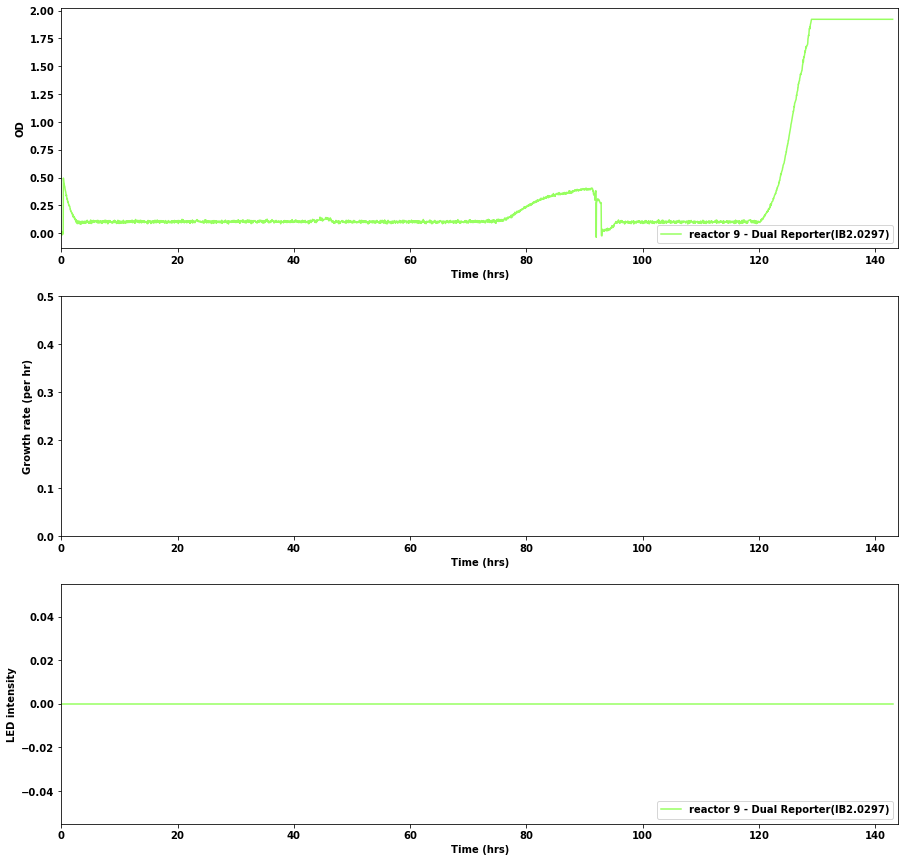

In [8]:
rid = 9
ax = all_data1[rid].plot()
# ax[0].set_ylim(0,0.5)

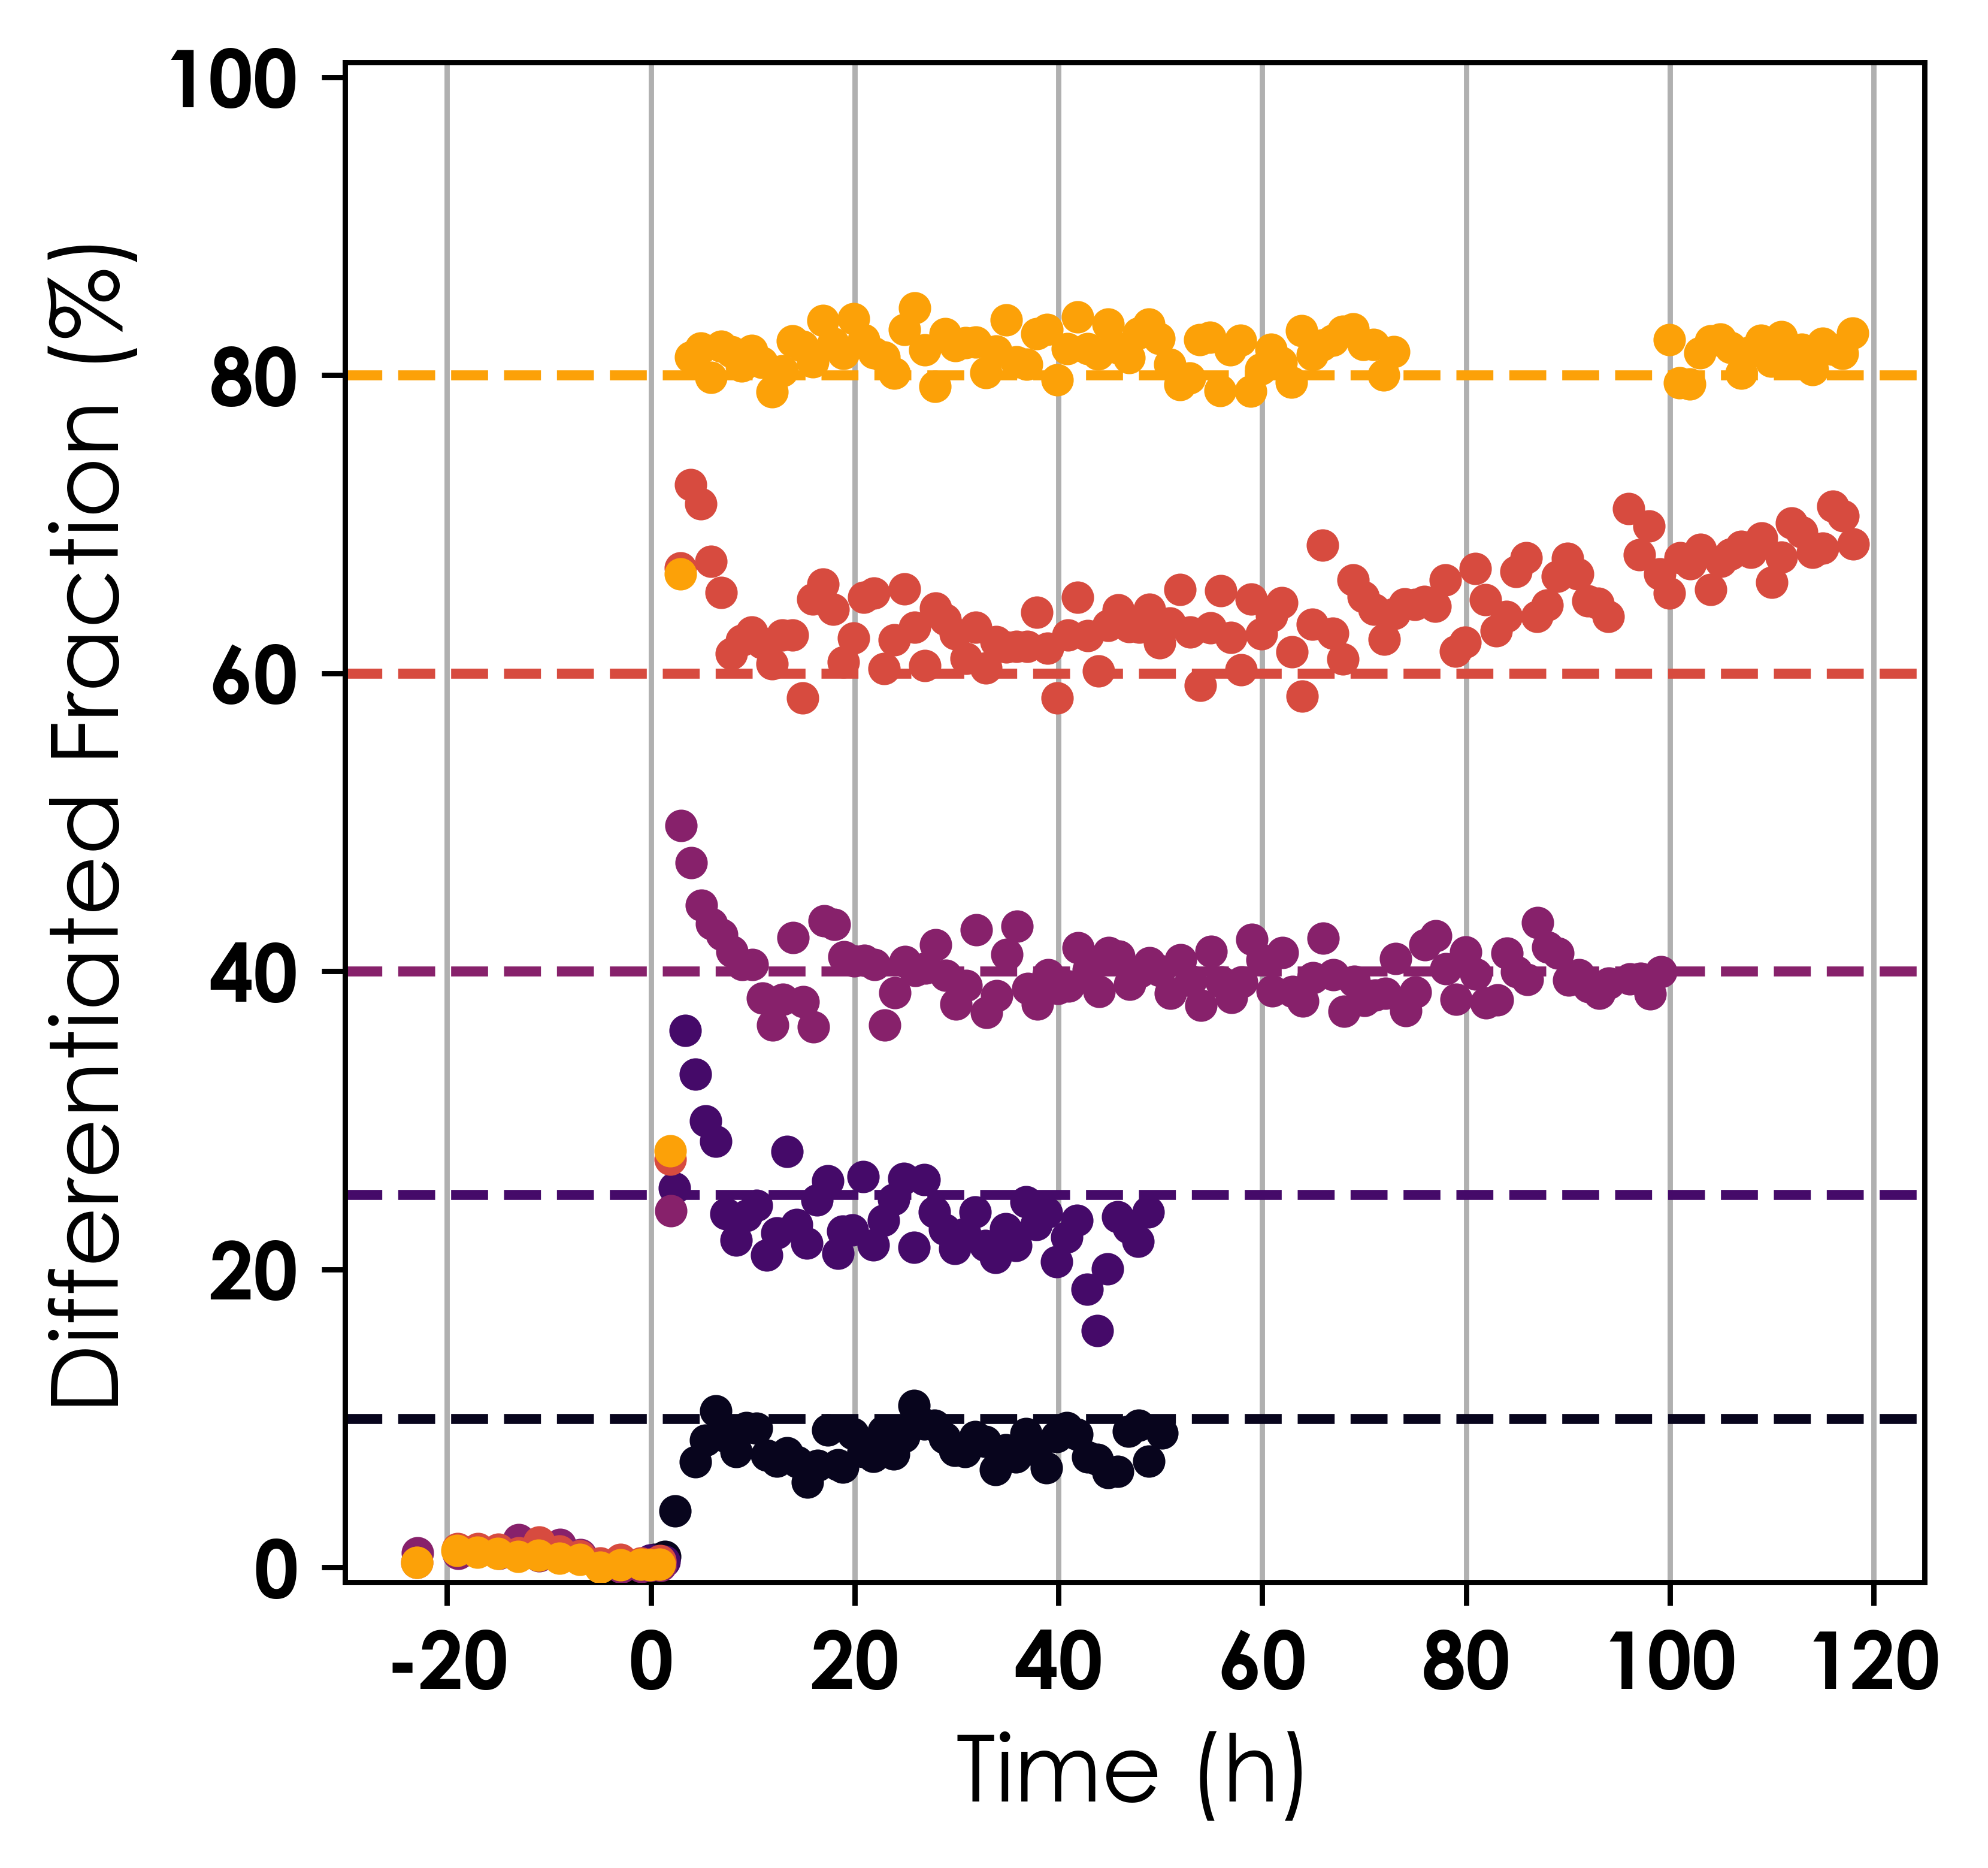

In [9]:
evenly_spaced_interval = np.linspace(0, 1,20)
fs=14
colorsi = [plt.cm.inferno(x) for x in evenly_spaced_interval]
colors =[colorsi[1],colorsi[4],colorsi[7],colorsi[11],colorsi[15]]
sz = 15
thresh1 = 0.5
thresh2 = 0.5
thresh_mc = 10
thresh_mn = 200
thresh_fp = [10, 200,50,100]
# fps = ['mCerulean','mNeonGreen','SSC-HLin']
fps = ['GRN-V-HLin','GRN-B-HLin','SSC-HLin']
t_del1 = [i for i in range(51,66)] #od malfunction in control reactor all_data reactor4
t_del2 = [i for i in range(51,67)] #od malfunction in control reactor all_data reactor5
t_del3 = [i for i in range(110,129)] #od malfunction in reservoir reactor all_data1 reactor7
t_del4 = [i for i in range(85,110)] #od malfunction in control reactor all_data1 reactor6

controls = [10,25,40,60,80]

fig, (ax1) = plt.subplots(1,1,figsize=(4.25, 4), dpi=800, facecolor='w', edgecolor='k')

t,rec_fraction,_= dual_mpc(all_data[4],t_shift = 7,t_del = [t_del1])
ax1.scatter(t,rec_fraction*100,s =sz , color=colors[0],zorder =10000)

t,rec_fraction,_= dual_mpc(all_data[5],t_shift = 7,t_del = [t_del2])
ax1.scatter(t,rec_fraction*100,s =sz , color=colors[1],zorder =10000)

t,rec_fraction,_= dual_mpc(all_data1[1],t_shift = 24,t_del = [t_del3])
ax1.scatter(t,rec_fraction*100,s =sz , color=colors[2],zorder =10000)

t,rec_fraction,_= dual_mpc(all_data1[5],t_shift = 24,t_del = [])
ax1.scatter(t,rec_fraction*100,s =sz , color=colors[3],zorder =10000)

t,rec_fraction,_= dual_mpc(all_data1[6],t_shift = 24,t_del = [t_del4])
ax1.scatter(t,rec_fraction*100,s =sz , color=colors[4],zorder =10000)

for jj,control in enumerate(controls):
    ax1.axhline(y = control, linestyle = '--', color = colors[jj])

tickls =[str(i) for i in controls]
ax1.set_ylim(-1,101)
ax1.set_title('',fontsize = fs+2,**cgfont)
xticks = [-20,0,20,40,60,80,100,120]
yticks = [0,20,40,60,80,100]
ax1.set_ylabel('Differentiated Fraction (%)',fontsize = fs,**cgfont)
ax1.set_xlabel('Time (h)',fontsize = fs,**cgfont)
ax1.set_xticks(xticks) 
ax1.set_xticklabels([str(i) for i in xticks], fontsize=fs-2,**cgfont)
ax1.set_yticks(yticks) 
ax1.set_yticklabels([str(i) for i in yticks], fontsize=fs-2,**cgfont)
ax1.xaxis.grid(True)
fig.tight_layout()

plt.savefig('../plots'+'/Figure3b.eps',bbox_inches = 'tight')
plt.savefig('../plots'+'/Figure3b.png',bbox_inches = 'tight')
plt.savefig('../plots'+'/Figure3b.svg',bbox_inches = 'tight')


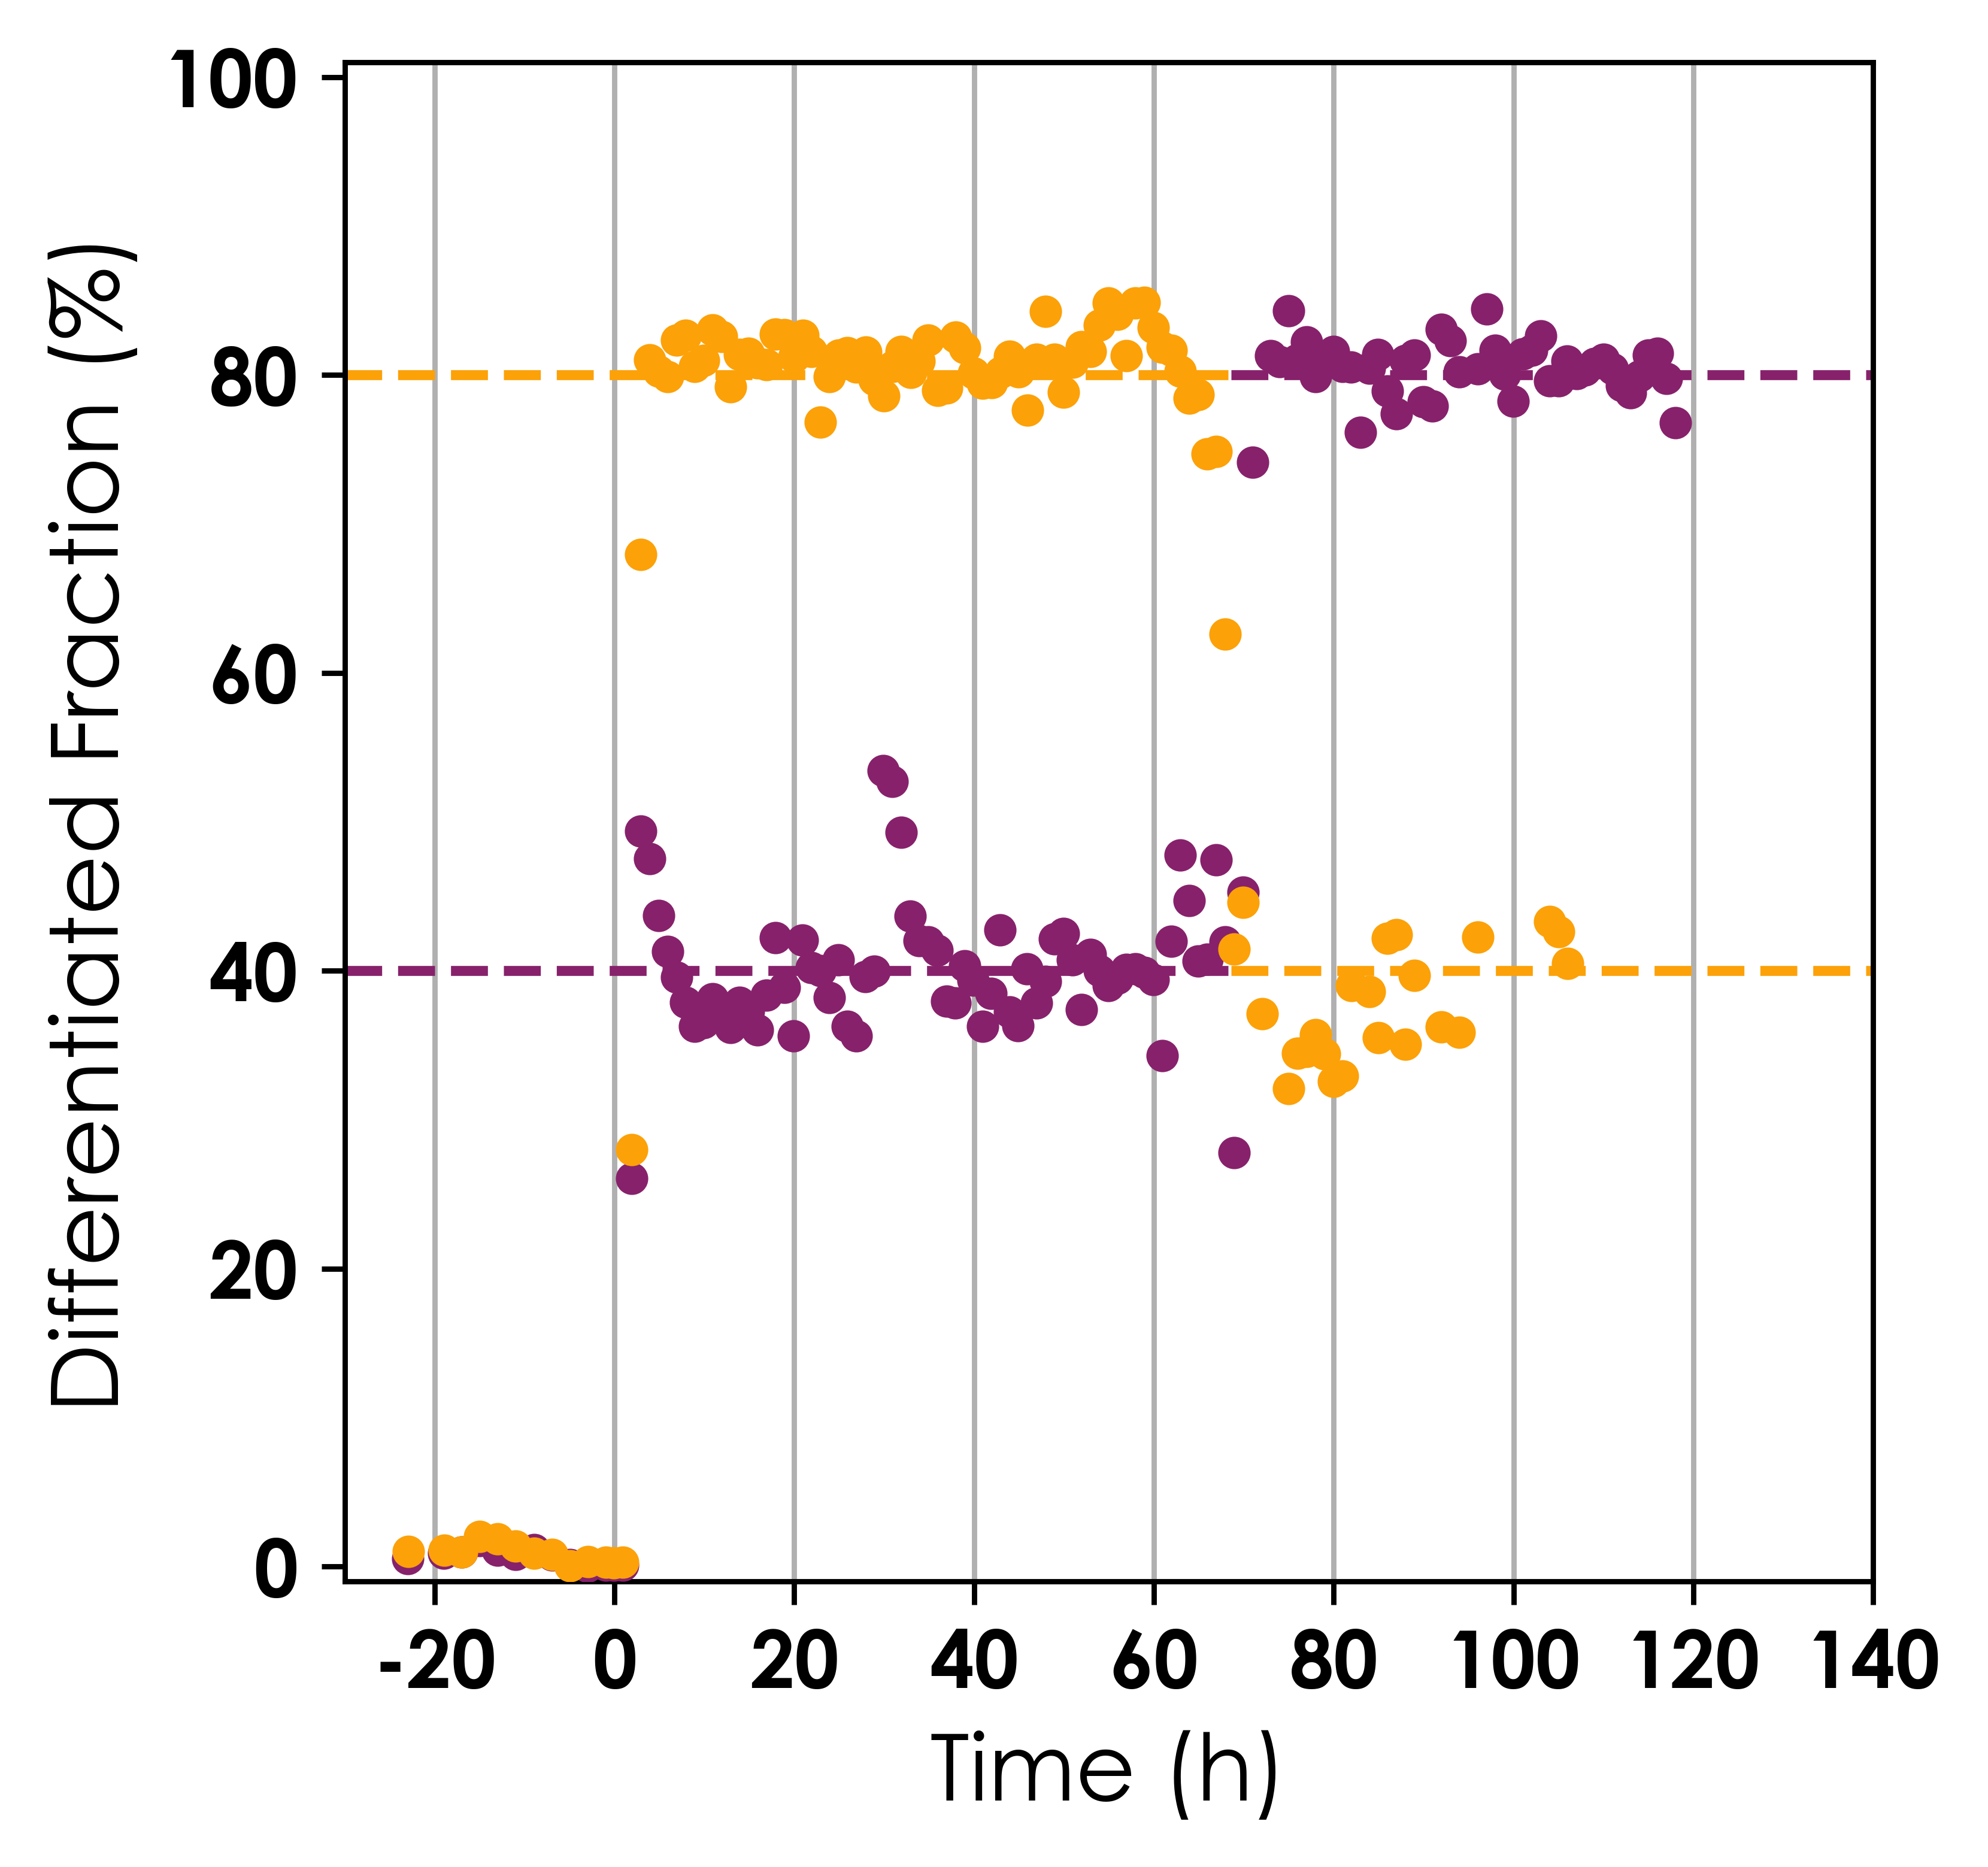

In [10]:
evenly_spaced_interval = np.linspace(0, 1,20)
fs =14
colorsi = [plt.cm.inferno(x) for x in evenly_spaced_interval]
colors =[colorsi[1],colorsi[4],colorsi[7],colorsi[11],colorsi[15]]

fig, (ax1) = plt.subplots(1,1,figsize=(4.25, 4), dpi=800, facecolor='w', edgecolor='k')

t,rec_fraction,_= dual_mpc(all_data1[4], t_shift = 24,t_del = [])
ax1.scatter(t,rec_fraction*100,s =sz , color=colors[2],zorder =10000)

t,rec_fraction,_= dual_mpc(all_data1[3], t_shift = 24,t_del = [])
ax1.scatter(t,rec_fraction*100,s =sz , color=colors[4],zorder =10000)

ax1.axhline(y = 40, xmin= 0, xmax = 0.58, linestyle = '--', color = colors[2])
ax1.axhline(y = 80, xmin= 0.58, xmax = 1, linestyle = '--', color = colors[2])


ax1.axhline(y = 80, xmin= 0, xmax = 0.58, linestyle = '--', color = colors[4])
ax1.axhline(y = 40, xmin= 0.58, xmax = 1, linestyle = '--', color = colors[4])

tickls =[str(i) for i in [40,80]]

ax1.set_ylim(-1,101)
ax1.set_title('',fontsize = fs+2,**cgfont)
xticks = [-20,0,20,40,60,80,100,120,140]
yticks = [0,20,40,60,80,100]
ax1.set_ylabel('Differentiated Fraction (%)', fontsize=fs,**cgfont)
ax1.set_xlabel('Time (h)', fontsize=fs,**cgfont)
ax1.set_xticks(xticks) 
ax1.set_xticklabels([str(i) for i in xticks], fontsize=fs-2,**cgfont)
ax1.set_yticks(yticks) 
ax1.set_yticklabels([str(i) for i in yticks], fontsize=fs-2,**cgfont)
ax1.xaxis.grid(True,zorder =-10000)
fig.tight_layout()

plt.savefig('../plots' +'/Figure3c.eps',bbox_inches = 'tight')
plt.savefig('../plots'+'/Figure3c.png',bbox_inches = 'tight')
plt.savefig('../plots'+'/Figure3c.svg',bbox_inches = 'tight')


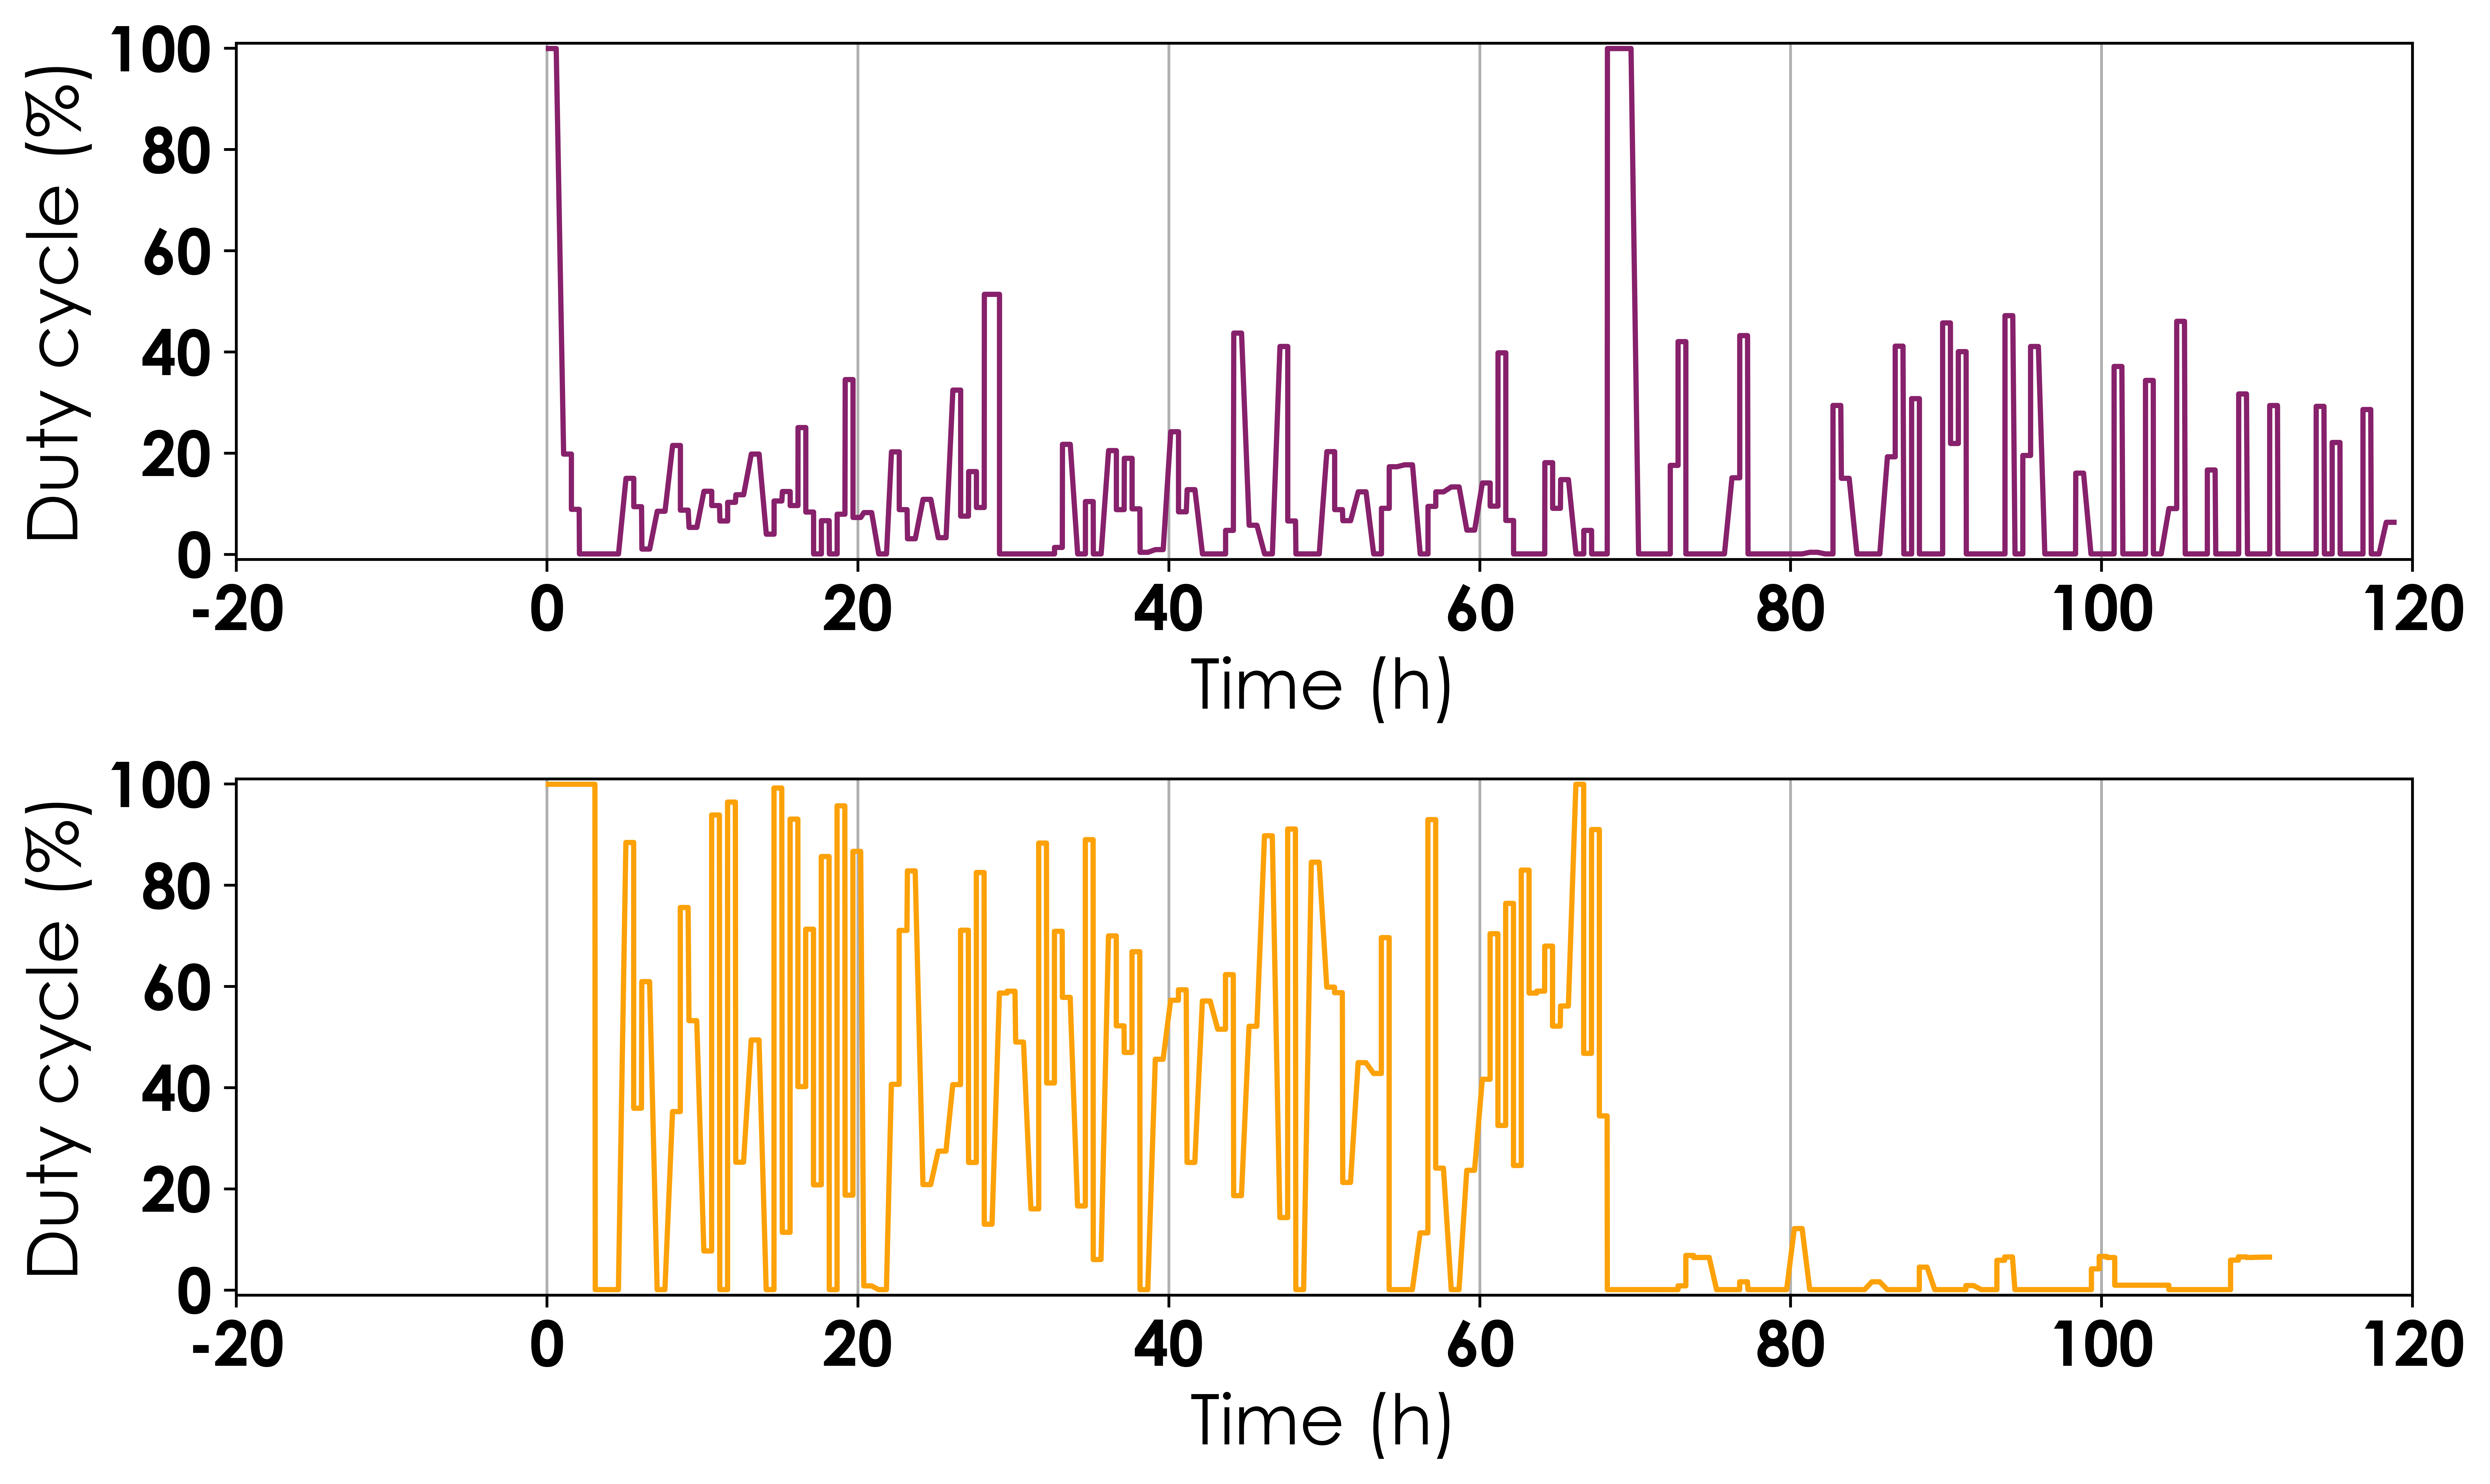

In [11]:
evenly_spaced_interval = np.linspace(0, 1,20)
fs=20
colorsi = [plt.cm.inferno(x) for x in evenly_spaced_interval]
colors =[colorsi[7],colorsi[15]]
t_del1 = [i for i in range(51,66)]
t_del2 = [i for i in range(51,67)]
t_del3 = [i for i in range(110,129)]
t_del4 = [i for i in range(110,129)]
t_del5 = [i for i in range(85,129)]
t_dels = [t_del1,t_del2,t_del3,t_del4,t_del5]
thresh1 = 0.5
thresh2 = 0.5
sz = 15
lims = [(-5,120),(-5,120),(-5,120),(-5,120),(-5,120),]
t_shift = [24,24,24,24,24]
xticks = [-20,0,20,40,60,80,100,120]
yticks = [0,20,40,60,80,100]
datas = [all_data1[4],all_data1[3]]
fig, axes = plt.subplots(2,1,figsize=(10,6), dpi=800, facecolor='w', edgecolor='k')

for jj,data in enumerate(datas):
    
    _,_,duty= dual_mpc(data, t_shift =t_shift[jj],t_del = t_dels[jj])
    axes[jj].plot(duty['rel_time_hrs']-t_shift[jj],duty['duty_fraction']*100,ls = '-',color =colors[jj],zorder =11000 )


    axes[jj].set_ylim(-1,101)
    axes[jj].set_xlim(lims[jj])

    axes[jj].set_ylabel('Duty cycle (%)', fontsize=fs,**cgfont)
    axes[jj].set_xlabel('Time (h)', fontsize=fs,**cgfont)

    axes[jj].set_xticks(xticks) 
    axes[jj].set_xticklabels([str(i) for i in xticks], fontsize=fs-2,**cgfont)
    axes[jj].set_yticks(yticks) 
    axes[jj].set_yticklabels([str(i) for i in yticks], fontsize=fs-2,**cgfont)
    axes[jj].xaxis.grid(True,zorder =-10000)
fig.tight_layout()
# plt.savefig('../plots' +'/dualMPCsignal2.eps',bbox_inches = 'tight')
# plt.savefig('../plots'+'/dualMPCsignal2.png',bbox_inches = 'tight')
# plt.savefig('../plots'+'/dualMPCsignal2.svg',bbox_inches = 'tight')


In [12]:
evenly_spaced_interval = np.linspace(0, 1,20)
fs=20
colorsi = [plt.cm.inferno(x) for x in evenly_spaced_interval]
colors =[colorsi[2],colorsi[4],colorsi[7],colorsi[11],colorsi[15]]
t_del1 = [i for i in range(51,66)]
t_del2 = [i for i in range(51,67)]
t_del3 = [i for i in range(110,129)]
t_del4 = [i for i in range(110,129)]
t_del5 = [i for i in range(85,129)]
t_dels = [t_del1,t_del2,t_del3,t_del4,t_del5]
thresh1 = 0.5
thresh2 = 0.5
sz = 15
lims = [(-5,50),(-5,50),(-5,120),(-5,120),(-5,120),]
t_shift = [7,7,24,24,24]
xticks = [-20,0,20,40,60,80,100,120]
yticks = [0,20,40,60,80,100]
datas = [all_data[4],all_data[5],all_data1[1],all_data1[5],all_data1[6]]
fig, axes = plt.subplots(5,1,figsize=(10, 15), dpi=800, facecolor='w', edgecolor='k')
labi = ['Target = 10%','Target = 20%','Target = 40%','Target = 60%','Target = 80%']

for jj,data in enumerate(datas):
    
    _,_,duty= dual_mpc(data, t_shift =t_shift[jj],t_del = t_dels[jj])
    axes[jj].plot(duty['rel_time_hrs']-t_shift[jj],duty['duty_fraction']*100,ls = '-',color =colors[jj],zorder =11000,label = labi[jj] )



    axes[jj].set_ylim(-1,101)
    axes[jj].set_xlim(lims[jj])
    L1 =axes[jj].legend(ncol = 1,fontsize=fs-4,loc = 'upper left',columnspacing = 0.4,title_fontsize = fs-6,handlelength = 0.8,handletextpad = 0.4)
    plt.setp(L1.texts,color =colors[jj], **cgfont)
    L1._legend_box.align = "center"
# ax1.set_title('',fontsize = fs+2,**cgfont)
# ticks =evenly_spaced_interval = [8/20,16/20]
# cbar = fig.colorbar(plt.cm.ScalarMappable( cmap='inferno'), ax=ax1, ticks=ticks)
# cbar.set_alpha(1)
# cbar.draw_all()
# cbar.ax.set_yticklabels(tickls,fontsize = fs-2,**cgfont) 
# cbar.ax.set_title('Target(%)',fontsize = fs-4,**cgfont)

    axes[jj].set_ylabel('Duty cycle (%)', fontsize=fs,**cgfont)
    axes[jj].set_xlabel('Time (h)', fontsize=fs,**cgfont)

    axes[jj].set_xticks(xticks) 
    axes[jj].set_xticklabels([str(i) for i in xticks], fontsize=fs-2,**cgfont)
    axes[jj].set_yticks(yticks) 
    axes[jj].set_yticklabels([str(i) for i in yticks], fontsize=fs-2,**cgfont)
    axes[jj].xaxis.grid(True,zorder =-10000)
fig.tight_layout()

# plt.savefig('../plots' +'/FigureS5.2.eps',bbox_inches = 'tight')
# plt.savefig('../plots'+'/FigureS5.2.png',bbox_inches = 'tight')
# plt.savefig('../plots'+'/FigureS5.2.svg',bbox_inches = 'tight')